In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [2]:
from external_plugins.spystats import tools

In [3]:
# My mac
#data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.SppN.mean()

5.1824128104220382

In [5]:
%time new_data = tools.toGeoDataFrame(pandas_dataframe=data,xcoord_name='LON',ycoord_name='LAT')

CPU times: user 3.76 s, sys: 40 ms, total: 3.8 s
Wall time: 3.82 s


## Let´s reproject to Alberts or something with distance

### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [6]:
new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

## Add log of the Biomass

In [7]:
new_data['logBiomass'] = new_data.apply(lambda x : np.log(x.plotBiomass),axis=1)

In [8]:
new_data['newLon'] = new_data.apply(lambda c : c.geometry.x, axis=1)
new_data['newLat'] = new_data.apply(lambda c : c.geometry.y, axis=1)

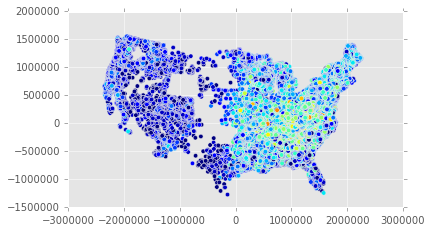

In [9]:
new_data.plot(column='SppN')

In [10]:
new_data['logBiomass'] = np.log(new_data.plotBiomass)

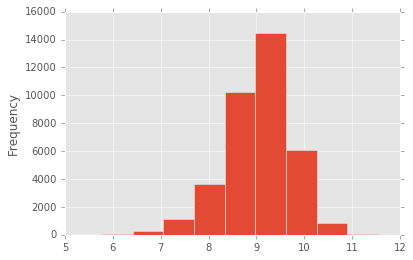

In [11]:
new_data.logBiomass.plot.hist()

## Linear Regression

In [12]:
### Now with statsmodels.api

#xx = X.SppN.values.reshape(-1,1)
#xx = sm.add_constant(xx)
#model = sm.OLS(Y.values.reshape(-1,1),xx)
import statsmodels.formula.api as smf
model = smf.ols(formula='logBiomass ~ SppN',data=new_data)
results = model.fit()
param_model = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     4187.
Date:                Fri, 03 Nov 2017   Prob (F-statistic):               0.00
Time:                        17:51:46   Log-Likelihood:                -36924.
No. Observations:               36845   AIC:                         7.385e+04
Df Residuals:                   36843   BIC:                         7.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.6217      0.007   1178.320      0.000         8.607     8.636
SppN           0.0807      0.001     64.709      0.000         0.078     0.083
==============================================================================
Omnibus:                     1709.757   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2473.616
Skew:                          -0.437   Prob(JB):                         0.00
Kurtosis:                       3.921   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
new_data['residuals1'] = results.resid

## The area is very big -> 35000 points. 
We need to make a subset of this


In [14]:
# COnsider the the following subregion
section = new_data[lambda x:  (x.LON > -90) & (x.LON < -85) & (x.LAT > 30) & (x.LAT < 35) ]

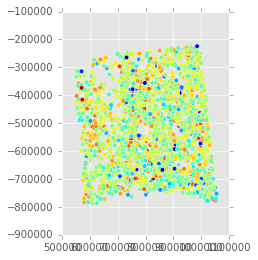

In [15]:
section.plot(column='residuals1')

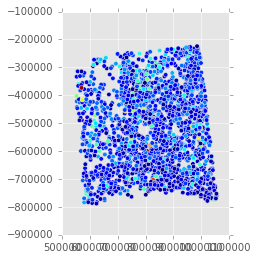

In [16]:
section.plot(column='plotBiomass')

In [17]:
section.shape

(1841, 46)

# Model Fitting Using a GLM 

The general model will have the form:
$$ Biomass(x,y) = \beta_1 AET + \beta_2 Age + Z(x,y) + \epsilon $$
Where:
$\beta_1$ and $\beta_2$ are model parameters, $Z(x,y)$ is the *Spatial Autocorrelation* process and $\epsilon \sim N(0,\sigma^2)$

In [18]:
len(data.lon)
#X = data[['AET','StandAge','lon','lat']]
X = section[['SppN','lon','lat']]
X = section[['SppN','newLon','newLat']]
#X = data[['lon','lat']]
Y = section['plotBiomass']
logY = section['logBiomass']
#Y = data[['SppN']]
## First step in spatial autocorrelation
#Y = pd.DataFrame(np.zeros(len(Y)))
## Let´s take a small sample only for the spatial autocorrelation
import numpy as np
sample_size = 2000
randindx = np.random.randint(0,X.shape[0],sample_size)
nX = X.loc[randindx]
nY = Y.loc[randindx]


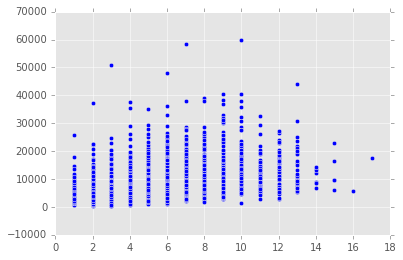

In [19]:
plt.scatter(X.SppN,Y)

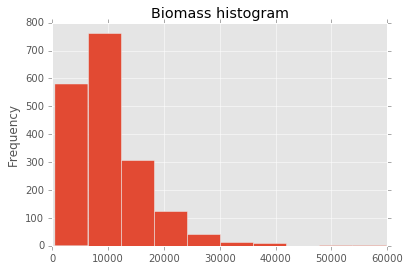

In [20]:
Y.plot.hist(title="Biomass histogram")

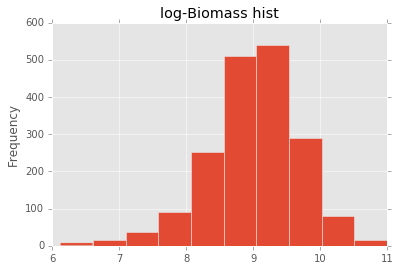

In [21]:
logY.plot.hist(title="log-Biomass hist")

In [22]:
## Let´s make a simple linear trend here.
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [23]:
### Now with statsmodels.api

#xx = X.SppN.values.reshape(-1,1)
#xx = sm.add_constant(xx)
#model = sm.OLS(Y.values.reshape(-1,1),xx)

model = smf.ols(formula='logBiomass ~ SppN',data=section)
results = model.fit()
param_model = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     320.9
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           2.87e-66
Time:                        17:51:48   Log-Likelihood:                -1752.0
No. Observations:                1841   AIC:                             3508.
Df Residuals:                    1839   BIC:                             3519.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.4869      0.033    261.094      0.000         8.423     8.551
SppN           0.0830      0.005     17.913      0.000         0.074     0.092
==============================================================================
Omnibus:                       75.080   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.571
Skew:                          -0.392   Prob(JB):                     1.19e-23
Kurtosis:                       3.873   Cond. No.                         15.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Residuals

In [24]:
Y_hat = results.predict(section)

In [25]:
ress = (section.logBiomass - Y_hat)

In [26]:
## They are eq. test this ress - results.resid

In [27]:
param_model.Intercept

8.4869335851853087

,0,1
Intercept,8.423182,8.550685
SppN,0.073933,0.092113


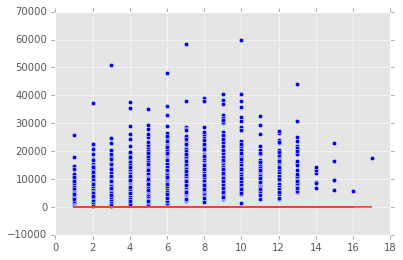

In [28]:
conf_int = results.conf_int(alpha=0.05)
plt.scatter(section.SppN,section.plotBiomass)
#plt.plot(section.SppN,param_model.Intercept + param_model.SppN * section.SppN)

plt.plot(section.SppN,Y_hat)
#plt.fill_between(Y_hat,Y_hat + conf_int , Y_hat - conf_int)
conf_int

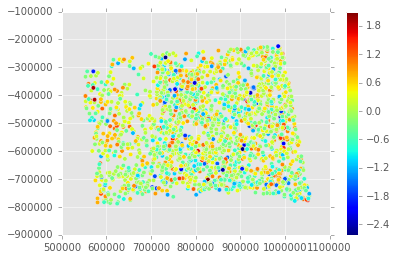

In [29]:
plt.scatter(section.newLon,section.newLat,c=results.resid)
plt.colorbar()

In [30]:
X = section[['newLon','newLat']].as_matrix()
Y = section[['logBiomass']].as_matrix()

In [31]:
dMM = tools._getDistanceMatrix(section)
dYY = tools._getDistResponseVariable(section,response_variable_name='logBiomass')
y = section['logBiomass']
yy = y.as_matrix()
#y2 = section[['logBiomass']]
#yy = y.values.reshape(-1,1)
#y2.shape

#dYY = sp.distance_matrix(yy,yy,p=2.0)

In [32]:
import scipy.spatial as sp


In [33]:
dM = sp.distance_matrix(X,X,p=2.0)
dY = sp.distance_matrix(Y,Y,p=2.0)


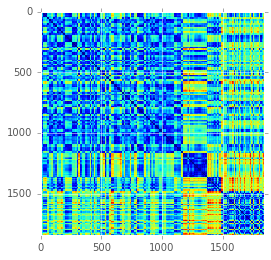

In [34]:
plt.imshow(dM)

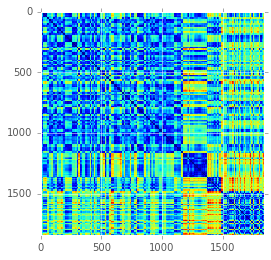

In [35]:
plt.imshow(dM)

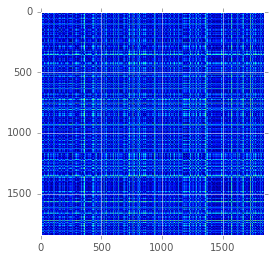

In [36]:
plt.imshow(dY)

In [37]:
#d = pd.DataFrame({ 'dist' : dM.flatten(), 'ydif' : dY.flatten()})
dist = dMM.flatten()
ydif = dYY.flatten()
d = pd.DataFrame({'dist': dist,'ydif':ydif})

### Calculate the semivariogram


In [38]:
vg = tools.Variogram(section,'logBiomass')

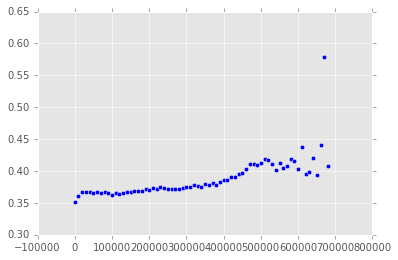

In [39]:
vg.calculate_empirical(n_bins=70)
plt.scatter(vg.lags,vg.empirical)

In [40]:
%time env = vg.calculateEnvelope(num_iterations=50)

CPU times: user 1min 16s, sys: 872 ms, total: 1min 16s
Wall time: 1min 17s


In [41]:
vg.plot()

AttributeError: 'Variogram' object has no attribute 'plot'

In [ ]:
env[['envhigh','variogram','envlow']].plot()

In [ ]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')

v = env.iloc[1:30,:]
#points = plt.scatter(vg.lags,vg.empirical)
 
plt.plot(v.lags,v.envlow,'k--')
plt.plot(v.lags,v.variogram,'o--',lw=2.0)
plt.plot(v.lags,v.envhigh,'k--')
plt.fill_between(v.lags,v.envlow,v.envhigh,alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Distance in meters")
plt.ylabel("Semivariance")
plt.legend(labels=['2.5%','emp. varig','97.5%'])
#ax = 
#points2 = plt.lines(vg.lags,vg.empirical,c='red')
#plt.show()

In [ ]:
env.shape

In [ ]:
d = pd.concat([env,vg.empirical],axis=1)
d

In [ ]:
ml = vg.distance_coordinates.flatten()
yl = vg.distance_responses.flatten()
X = np.vstack([ml,yl])
X.shape
n = np.random.shuffle(X)

In [ ]:
titi = tools.montecarloEnvelope(ml,yl,num_iterations=99)

In [ ]:
titi

In [ ]:
np.random.shuffle(X)

In [ ]:
plt.plot(X)

In [ ]:
n_bins = 100
distances = dMM.flatten()
mdist = min(distances)
Mdist = max(distances)
partitions = np.linspace(mdist,Mdist,n_bins)

In [ ]:
cosas =  map(lambda (i,x) : 0.5* (d[ ( d.dist < partitions[i+1]) & (d.dist>partitions[i])].ydif.mean()),enumerate(partitions[:len(partitions) - 1]))

In [ ]:
plt.scatter(partitions[:len(partitions) -1] ,cosas)

In [ ]:
c.ydif.mean()

In [ ]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, active_dims = [0,1] )

In [ ]:
results.resid.plot.hist()

In [ ]:
model = gf.gpr.GPR(section[['newLon','newLat']].as_matrix(),results.resid.values.reshape(-1,1),k)

In [ ]:
%time model.optimize()

In [ ]:
model.get_parameter_dict()

In [ ]:
import numpy as np
Nn = 300
dsc = section
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [ ]:
predicted_coordinates.shape

In [ ]:
means,variances = model.predict_y(predicted_coordinates)

In [ ]:
means = map(lambda x : np.exp(x),means)
variances = map(lambda x : np.exp(x),variances)

In [ ]:
sum(means)

In [ ]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
#plt.pcolor(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn))) #,cmap=plt.cm.Greens)
plt.pcolormesh(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn)))
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("VAriance Biomass")
plt.colorbar()

In [ ]:
import cartopy
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
#ax.set_extent([-100, -60, 20, 50])
ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn),linewidths=2,colors='k',linestyles='dotted',levels=[4.0,5.0,6.0,7.0,8.0])
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,c=new_data.error,edgecolors='',transform=proj,cmap=plt.cm.Greys,alpha=0.2)
plt.colorbar(mm)
plt.title("Predicted Species Richness")


#(x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50)

## Residuals of $ Biomass ~ SppRich + Z(x,y) + \epsilon $
Using all data



## Model Analysis


In [ ]:
model.kern

In [ ]:
model.likelihood

## Let's calculate the residuals

In [ ]:
X_ = section[['LON','LAT']]
%time resid_hat, resid_hat_variance = model.predict_y(X_)

In [ ]:
resid_hat.shape

In [ ]:
qr_errors = qr_errors.values.reshape(len(qr_errors),1)

In [ ]:
#new_data= new_data.assign(error=lambda y : (y.SppN - y.pred_y)**2 )
sqr_error_errors = pd.DataFrame((qr_errors - resid_hat)**2)

In [ ]:
print(sqr_error_errors[0].mean())
print(sqr_error_errors[0].std())

In [ ]:
true_error

In [ ]:
sqr_error_errors.mean()

In [ ]:
k.ARD?